In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
import sys
sys.path.append('../../')
titanic_df = pd.read_csv('titanic_data/data.csv')

In [2]:
import tablemage as tm
analyzer = tm.Analyzer(titanic_df, test_size=0.2, name='Titanic Dataset')
analyzer

UPDT: Analyzer initialized for dataset 'Titanic Dataset'. 


Titanic Dataset 
----------------------------------------------------------------------------------------
Train shape: (712, 12)                      Test shape: (179, 12)                       
----------------------------------------------------------------------------------------
Categorical variables:
  'Cabin', 'Embarked', 'Name', 'Sex', 'Ticket' 
                                                                                        
Numeric variables:
  'Age', 'Fare', 'Parch', 'PassengerId', 'Pclass', 'SibSp', 'Survived' 

In [4]:
output = analyzer.logit(target="Survived", predictors=["Age", "Sex"], alpha=0)
output

NOTE: Train dataset: dropped 140 examples with missing values out of 712 total examples. 
NOTE: Test dataset: dropped 37 examples with missing values out of 179 total examples. 


Logistic Regression Report
----------------------------------------------------------------------------------------
Target variable:
  'Survived' 
                                                                                        
Predictor variables (2):
  'Age', 'Sex' 
----------------------------------------------------------------------------------------
Metrics:
  Train (572)                                Test (142) 
    F1:     0.715                              F1:     0.714 
    Acc:    0.781                              Acc:    0.775 
    AUROC:  0.772                              AUROC:  0.772 
----------------------------------------------------------------------------------------
Coefficients:
                            Estimate         Std. Error            p-value 
  Predictor                                                                
  const                        1.201              0.287               0.00 
  Sex::male                   -2.491              0

In [5]:
output.step()

UPDT: Backward selection removed 1 predictor: 'Age'. 
NOTE: Train dataset: dropped 140 examples with missing values out of 712 total examples. 
NOTE: Test dataset: dropped 37 examples with missing values out of 179 total examples. 


Logistic Regression Report
----------------------------------------------------------------------------------------
Target variable:
  'Survived' 
                                                                                        
Predictor variables (1):
  'Sex' 
----------------------------------------------------------------------------------------
Metrics:
  Train (572)                                Test (142) 
    F1:     0.715                              F1:     0.714 
    Acc:    0.781                              Acc:    0.775 
    AUROC:  0.765                              AUROC:  0.761 
----------------------------------------------------------------------------------------
Coefficients:
                            Estimate         Std. Error            p-value 
  Predictor                                                                
  const                        1.144              0.162                0.0 
  Sex::male                   -2.497              0.208   

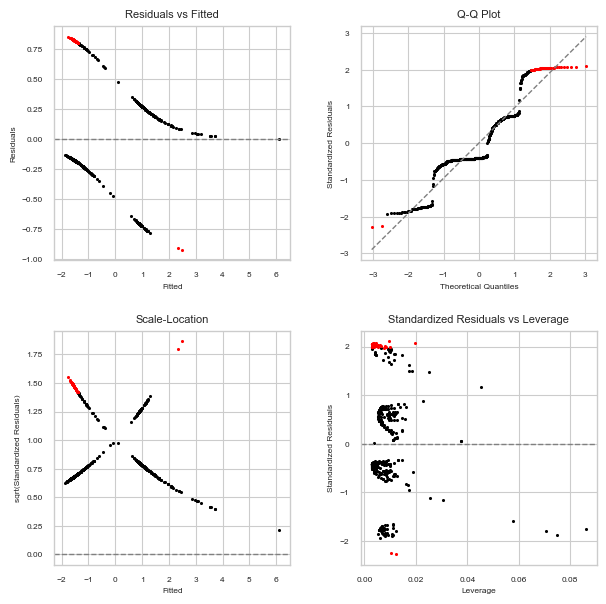

In [5]:
output.plot_diagnostics("train", show_outliers=True)

In [12]:
output.metrics("both")

Logit Linear Model
Dataset Statistic                   
train   accuracy             0.77972
        f1                  0.717489
        precision           0.747664
        recall              0.689655
        roc_auc             0.821203
        n_obs                    572
test    accuracy            0.774648
        f1                  0.714286
        precision           0.740741
        recall              0.689655
        roc_auc             0.862274
        n_obs                    142

In [5]:
output.coefs()

,Coefficient (Std. Error),P-value
const,0.887 (0.264),0.001
Sex::male,-2.382 (0.213),0.000
Age,-0.006 (0.007),0.395
Fare,0.011 (0.003),0.000


In [10]:
output.step().statsmodels_summary()

NOTE: Train dataset: dropped 140 examples with missing values out of 712 total examples. 
NOTE: Test dataset: dropped 37 examples with missing values out of 179 total examples. 


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  572
Model:                          Logit   Df Residuals:                      569
Method:                           MLE   Df Model:                            2
Date:                Mon, 25 Nov 2024   Pseudo R-squ.:                  0.2535
Time:                        15:04:02   Log-Likelihood:                -288.31
converged:                       True   LL-Null:                       -386.22
Covariance Type:                  HC3   LLR p-value:                 2.997e-43
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7345      0.194      3.781      0.000       0.354       1.115
Sex::male     -2.4085      0.212    -11.358      0.000      -2.824      -1.993
Fare           0.0103      0.003      3.551      0.000       0.005       0.016
==============================================================================
"""

In [8]:
analyzer.classify(
    target="Survived", 
    predictors=["Age", "Sex", "Fare"],
    models=[
        tm.ml.LinearC('no_penalty')
    ]
).metrics('test')

INFO: Evaluating model 'LinearC(no_penalty)'. 
WARN: Train data: dropped 140 rows with missing values out of a total of 712 rows. 
PROG: Fitting 'LinearC(no_penalty)'. Search method: GridSearchCV (1 fits per fold, 5 
      total fits).  
PROG: Optimal threshold set for 'LinearC(no_penalty)' via F1 score. 
WARN: Test data: dropped 37 rows with missing values out of a total of 179 rows. 
INFO: Successfully evaluated model 'LinearC(no_penalty)'. 


,LinearC(no_penalty)
Statistic,
accuracy,0.760563
f1,0.711864
precision,0.7
recall,0.724138
roc_auc,0.862274
n_obs,142


In [5]:
output = analyzer.glm(
    family='binomial',
    target='Survived',
    predictors=[
        'Pclass',
        'Sex',
        'Age',
        'Fare',
        'Parch'
    ]
)

WARN: Train data: dropped 140 rows with missing values out of a total of 712 rows. 
WARN: Test data: dropped 37 rows with missing values out of a total of 179 rows. 
WARN: Train data: dropped 140 rows with missing values out of a total of 712 rows. 
WARN: Test data: dropped 37 rows with missing values out of a total of 179 rows. 


In [7]:
output.step().statsmodels_summary()

WARN: Train data: dropped 140 rows with missing values out of a total of 712 rows. 
WARN: Train data: dropped 140 rows with missing values out of a total of 712 rows. 
WARN: Train data: dropped 140 rows with missing values out of a total of 712 rows. 
WARN: Train data: dropped 140 rows with missing values out of a total of 712 rows. 
WARN: Train data: dropped 140 rows with missing values out of a total of 712 rows. 
WARN: Train data: dropped 140 rows with missing values out of a total of 712 rows. 
WARN: Train data: dropped 140 rows with missing values out of a total of 712 rows. 
WARN: Train data: dropped 140 rows with missing values out of a total of 712 rows. 
WARN: Train data: dropped 140 rows with missing values out of a total of 712 rows. 
WARN: Train data: dropped 140 rows with missing values out of a total of 712 rows. 
WARN: Train data: dropped 140 rows with missing values out of a total of 712 rows. 
WARN: Train data: dropped 140 rows with missing values out of a total of 712

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                  572
Model:                            GLM   Df Residuals:                      568
Model Family:                Binomial   Df Model:                            3
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -267.31
Date:                Sat, 21 Sep 2024   Deviance:                       534.62
Time:                        21:10:53   Pearson chi2:                     595.
No. Iterations:                     5   Pseudo R-squ. (CS):             0.3402
Covariance Type:                  HC3                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.4386      0.544      8.161      0.000       3.373       5.505
male::Sex     -2.4835      0.219    -11.327      0.000      -2.913      -2.054
Pclass        -1.1242      0.155     -7.239      0.000      -1.429      -0.820
Age           -0.0281      0.009     -3.246      0.001      -0.045      -0.011
==============================================================================
"""

In [8]:
analyzer.load_data_checkpoint()
analyzer.drop_highly_missing_vars()
report = analyzer.classify(
    target='Survived',
    models=[
        tm.ml.TreesC(type='random_forest'),
        tm.ml.LinearC(type='l2')
    ]
)

INFO: Working DataFrames reset to original DataFrames. Shapes of train, test DataFrames: 
      (712, 12), (179, 12). 
INFO: Dropped variables 'Cabin' with at least 50.0% of values missing. 
INFO: Evaluating model 'TreesC(random_forest)'. 
WARN: Train data: dropped 142 rows with missing values out of a total of 712 rows. 
PROG: Fitting 'TreesC(random_forest)'. Search method: OptunaSearchCV (100 trials, 500 
      total fits).  
PROG: Optimal threshold set for 'TreesC(random_forest)' via F1 score. 
WARN: Test data: dropped 37 rows with missing values out of a total of 179 rows. 
INFO: Successfully evaluated model 'TreesC(random_forest)'. 
INFO: Evaluating model 'LinearC(l2)'. 
WARN: Train data: dropped 142 rows with missing values out of a total of 712 rows. 
PROG: Fitting 'LinearC(l2)'. Search method: OptunaSearchCV (100 trials, 500 total fits). 
       
PROG: Optimal threshold set for 'LinearC(l2)' via F1 score. 
WARN: Test data: dropped 37 rows with missing values out of a total of 1

In [9]:
report

ML Classification Report
----------------------------------------------------------------------------------------
Target variable:
  'Survived' 
                                                                                        
Predictor variables:
  'PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 
  'Embarked' 
                                                                                        
Models evaluated:
  'TreesC(random_forest)', 'LinearC(l2)' 
                                                                                        
Feature selectors:
  None 
----------------------------------------------------------------------------------------
Best models:
  1. 'TreesC(random_forest)'                 Test AUROC: 0.87213 
  2. 'LinearC(l2)'                           Test AUROC: 0.83744 

In [11]:
report.metrics('test')

,TreesC(random_forest),LinearC(l2)
Statistic,,
accuracy,0.78169,0.816901
f1,0.725664,0.77193
precision,0.745455,0.785714
recall,0.706897,0.758621
roc_auc,0.872126,0.837438
n_obs,142,142


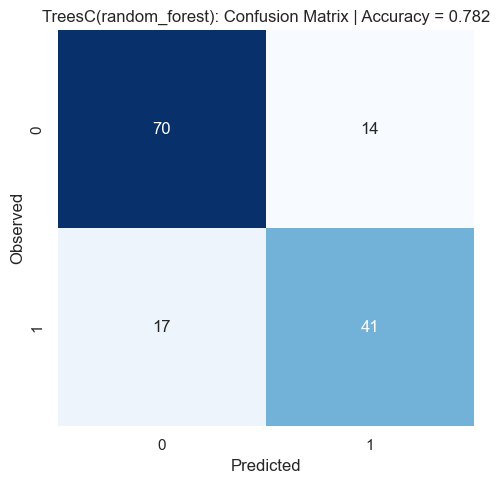

In [14]:
report.plot_confusion_matrix('TreesC(random_forest)', 'test')